## Homework 6 :  Physics 403, S25
Aidan Meador-Woodruff (ameadorw@ur.rochester.edu)

Due: Friday 28 March, 2025

In [3]:
# Glorious import statements
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad, tplquad
#from scipy.integrate import cumulative_trapezoid
#from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import chi2

### Problem 1 : Bayesian Model Selection and the Bayes Factor

*We are given a dataset with a linear hypothesis.*

---
*a).* 

[ 0.31599852  0.79217779 -0.22427636]


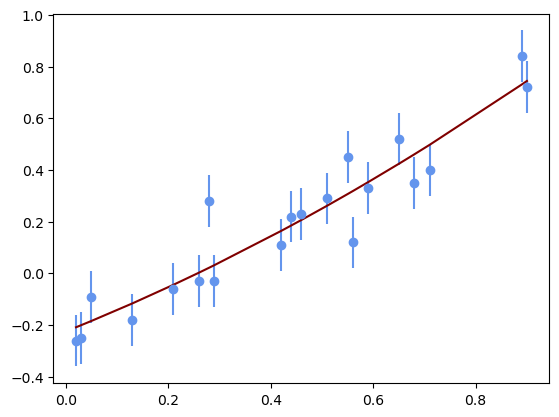

In [4]:
# Import the data and visualize it like a good physicist would.
data = np.loadtxt("model_selection.txt").transpose()
x,y, dy = data
plt.errorbar(x,y,yerr=dy, fmt='o',color='cornflowerblue',label='Dataset 1');

coeff = np.polyfit(x,y,2)
print(coeff)
line = np.polyval(coeff, x)
plt.plot(x,line, color='maroon')

In [5]:
# Likelihood function
def likelihood(a,b):
    'Define the log-likelihood.'
    model = a + b * x
    return np.exp(-0.5 * np.sum(((y - model) / dy) ** 2))

# Prior function (constant within the given range)
prior = 1# / 16  # Since priors are uniform over [-2,2] for both a and b

# Compute the marginal likelihood
pD_given_M1, _ = dblquad(lambda a, b: likelihood(a, b) * prior,
                         -2, 2,  # Limits for a
                         lambda _: -2, lambda _: 2)  # Limits for b

print("p(D | M1) =", pD_given_M1)

p(D | M1) = 3.4976959935512906e-07


In [6]:
# Define the likelihood function for a quadratic model y = a + bx + cx^2
def likelihood_quad(a,b,c):
    'Define the log-likelihood.'
    model = a + b * x + c*x**2
    return np.exp(-0.5 * np.sum(((y - model) / dy) ** 2))

# Define the prior: uniform over [-2,2] for a, b, c
prior_quad = 1# / 4**3  # Since priors are uniform over [-2,2]^3

# Compute Bayesian evidence p(D | M2)
pD_given_M2, _ = tplquad(lambda a, b, c: likelihood_quad(a, b, c) * prior_quad,
                         -2, 2, lambda _: -2, lambda _: 2, lambda _, __: -2, lambda _, __: 2)

# Compute Bayes factor B_12 = p(D | M1) / p(D | M2)
Bayes_factor = pD_given_M1 / pD_given_M2

print("Bayesian Evidence p(D | M2):", pD_given_M2)
print("Bayes Factor B_12:", Bayes_factor)


Bayesian Evidence p(D | M2): 4.563363411610294e-07
Bayes Factor B_12: 0.7664732518677585


### Problem 2 : Frequentist Model Selection and Wilks' Theorem

*We now consider the model selection as frequentists to determine if a linear or quadratic fit is better.*

---
*a). We first consider a model $M_1$ in which the data are described by a linear relationship $y=a+bx$. We minimize the $\chi^2$ test statistic and find $\chi^2_{M_1}$ as well as the best estimates $\hat{a},\hat{b}$. We plot it and also find the $p$-value*.

The $\chi^2_{M_1}$ test statistic is given to us as 
$$\chi^2_{M_1} = \sum_{i=1}^N \left(\frac{y_i - (a+bx_i)}{\sigma_i}\right)^2$$

Below in our code we solve for the best fits by using the weighted means of our variables

Best-fit parameters:
a_hat = -0.2630
b_hat = 1.0684
Chi-square (χ²_M1) = 20.8850
Degrees of freedom = 18
P-value = 0.2853


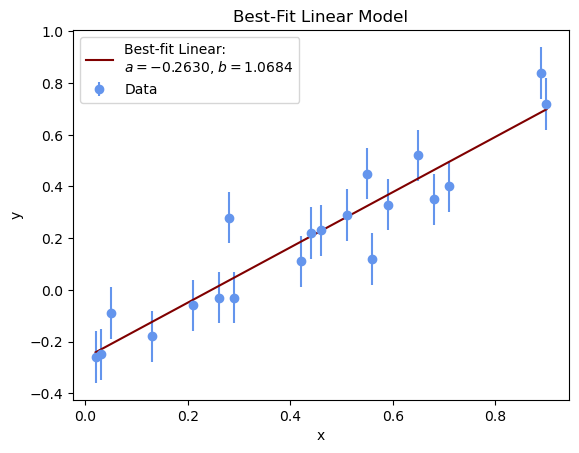

In [10]:
# 2a. Linear Model M1 (Frequentist)

## Number of data points
N = len(x)

# Weights for our variables
w = 1 / dy**2

# Weighted mean of x and y 
x_bar = np.sum(w * x) / np.sum(w)
y_bar = np.sum(w * y) / np.sum(w)

# Best-fit of the parameter a and b 
b_hat = np.sum(w * (x - x_bar) * (y - y_bar)) / np.sum(w * (x - x_bar)**2)
a_hat = y_bar - b_hat * x_bar

# chi^2 sum as given in the problem, dy is out sigma.
chi2_M1 = np.sum(((y - (a_hat + b_hat * x)) / dy) ** 2)

# Using the hint that we can find the p value by an N-2 dof chi^2. 
dof = N - 2
# Used the chi2 cdf from scipy because I am an exceptionally lazy individual.
p_value = 1 - chi2.cdf(chi2_M1, dof)

### ------------ Plotting and such
print(f"Best-fit parameters:")
print(f"a_hat = {a_hat:.4f}")
print(f"b_hat = {b_hat:.4f}")
print(f"Chi-square (χ²_M1) = {chi2_M1:.4f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p_value:.4f}")

plt.errorbar(x, y, yerr=dy, fmt='o', label='Data', color='cornflowerblue')
plt.plot(x, a_hat + b_hat*x, label=f'Best-fit Linear: \n$a={a_hat:.4f}$, $b={b_hat:.4f}$', color='maroon')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best-Fit Linear Model')
plt.legend();

This seems like a pretty decent fit. The $p$-value is statistically significant. If we check this with a built in linear regression, we get the same parameters and $p$-value (albeit, it's probably being solved exactly the same way lol, but a decent-ish sanity check).

*b). Now, we wish to do the same for a quadratic model.*

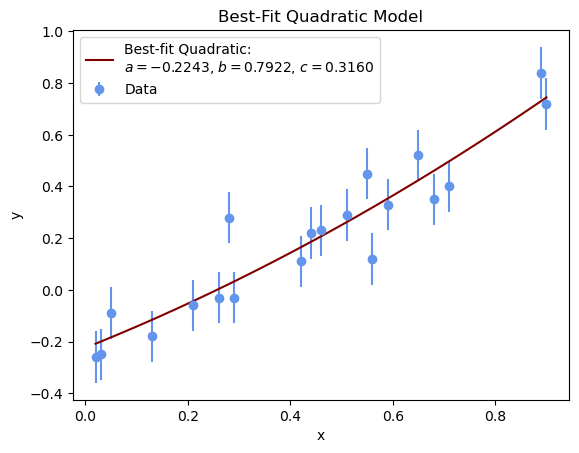

Best-fit parameters:
a_hat = -0.2243
b_hat = 0.7922
c_hat = 0.3160
Chi-square (χ²_M2) = 19.8848
Degrees of freedom = 17
P-value = 0.2802


In [14]:
# 2b. Quadratic Model M2 (Frequentist)

# Number of data points
N = len(x)

# Compute weights
w = 1 / dy**2

# Compute sums for normal equations
S_w = np.sum(w)
S_x = np.sum(w * x)
S_x2 = np.sum(w * x**2)
S_x3 = np.sum(w * x**3)
S_x4 = np.sum(w * x**4)

S_y = np.sum(w * y)
S_xy = np.sum(w * x * y)
S_x2y = np.sum(w * x**2 * y)

# Construct normal equation matrix and RHS vector
M = np.array([
    [S_w,  S_x,  S_x2],
    [S_x,  S_x2, S_x3],
    [S_x2, S_x3, S_x4]
])

b_vec = np.array([S_y, S_xy, S_x2y])

# Solve for best-fit parameters using np.linalg.solve
a_hat, b_hat, c_hat = np.linalg.solve(M, b_vec)

# Compute chi-square statistic for M2
chi2_M2 = np.sum(((y - (a_hat + b_hat * x + c_hat * x**2)) / dy) ** 2)

# Compute p-value using chi-square distribution with N-3 degrees of freedom
dof = N - 3
p_value_M2 = 1 - chi2.cdf(chi2_M2, dof)

# Plot the data and the best-fit quadratic curve
plt.errorbar(x, y, yerr=dy, fmt='o', label='Data', color='cornflowerblue')
x_fit = np.linspace(min(x), max(x), 1000)
y_fit = a_hat + b_hat * x_fit + c_hat * x_fit**2
plt.plot(x_fit, y_fit, label=f'Best-fit Quadratic: \n$a={a_hat:.4f}$, $b={b_hat:.4f}$, $c={c_hat:.4f}$', color='maroon')

# Labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Best-Fit Quadratic Model')
plt.legend()

# Show the plot
plt.show()

# Output results
print(f"Best-fit parameters:")
print(f"a_hat = {a_hat:.4f}")
print(f"b_hat = {b_hat:.4f}")
print(f"c_hat = {c_hat:.4f}")
print(f"Chi-square (χ²_M2) = {chi2_M2:.4f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p_value_M2:.4f}")


In [13]:
# 1c. Comparison of Models

# --- M1: Linear model (y = a + bx) ---
# Compute weighted means for x, y
x_bar = np.sum(w * x) / np.sum(w)
y_bar = np.sum(w * y) / np.sum(w)

# Best-fit parameters for M1
b_hat_M1 = np.sum(w * (x - x_bar) * (y - y_bar)) / np.sum(w * (x - x_bar)**2)
a_hat_M1 = y_bar - b_hat_M1 * x_bar

# Compute chi-square for M1
chi2_M1 = np.sum(((y - (a_hat_M1 + b_hat_M1 * x)) / dy) ** 2)

a_hat_M2 = a_hat 
b_hat_M2 = b_hat
c_hat_M2 = c_hat
# Compute chi-square for M2
chi2_M2 = np.sum(((y - (a_hat_M2 + b_hat_M2 * x + c_hat_M2 * x**2)) / dy) ** 2)

# Compute the chi-square difference
delta_chi2 = chi2_M1 - chi2_M2

# Compute p-value from chi-square distribution with 1 degree of freedom
p_value_delta_chi2 = 1 - chi2.cdf(delta_chi2, 1)

# Output results
print(f"Chi-square for M1 (linear model): {chi2_M1:.4f}")
print(f"Chi-square for M2 (quadratic model): {chi2_M2:.4f}")
print(f"Chi-square difference (∆χ²): {delta_chi2:.4f}")
print(f"P-value for ∆χ²: {p_value_delta_chi2:.4f}")


Chi-square for M1 (linear model): 20.8850
Chi-square for M2 (quadratic model): 19.8848
Chi-square difference (∆χ²): 1.0003
P-value for ∆χ²: 0.3172
